# Text Complexity

This notebook computes the text complexity of individual periodicals, as measured by the Flesch reading ease, a normalized version of the type-token ratio, and a measure for syntactic complexity based on part-of-speech tags. More details on the measures and their interpretation, as well as an analysis of the results, can be found in the manuscript **[Enter Link Here]**. The computed complexity measure will be stored in an additional file, based on which they can be processed in the notebook `02_text_complexity_tests`.

This notebook was mainly provided by Han Tran, Know-Center GmbH and is supposed to work with the pickled dataframe from December 23rd, 2020.

In [1]:
# load file
import pandas as pd
infile = '../data/processed/texts_new_20201223.p'
df = pd.read_pickle(infile)

In [10]:
from nltk import ngrams
from collections import Counter
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

from nltk.tokenize import sent_tokenize, word_tokenize
def remove_short_sentences(df, col='filtered_text', limit=3): 
    tmp_2 = []
    for v, i in zip(df['language'], df['text']):
        sent_len = []
        tmp = []
        sents = pd.Series(sent_tokenize(i, language=v.lower()))
        for s in sents:
            sent_len.append(len([m for m in word_tokenize(s, language=v.lower()) 
                                if any([j.isalnum() for j in m])]))

        sent_len = pd.Series(sent_len)
        sent_len = sent_len[sent_len >= limit]
        sents = sents.loc[sent_len.index]
        tmp = ' '.join(sents)
        tmp_2.append(tmp)
    df[col] = tmp_2
    return df


def _compute_entropy(grams, mode='tri'):
    a = pd.DataFrame(Counter(grams), index=['count']).T
    a['prop'] = a['count']/sum(a['count'])
    if mode != 'tri':
        a['ent'] = a['prop']*np.log2(a['prop'])
        return 2**(-sum(a['ent']))
    
    a['2-index'] = [i[:-1] for i in a.index]
    cnt_2_grams = dict()
    for i, j in zip(a['count'], a['2-index']):
        cnt_2_grams[j] = cnt_2_grams.get(j, 0) + i
    
    b = pd.DataFrame(cnt_2_grams, index=['count']).T
    b['prop'] = b['count']/np.sum(b['count'])

    a['2-gram'] = [b.loc[i, 'prop'] for i in a['2-index']]
    a['p3'] = a['prop']/a['2-gram']
        
    a['ent'] = a['p3']*np.log2(a['p3'])
    return 2**(-sum(a['ent'])/a.shape[0])


def reduce_tag_es(es):
    # 1. VERB create only V
    es =['V' if i[0]=='V' else i for i in es]
    replace_list = {
        # 2. CON conjunction
        'CON': ['CC', 'CCAD', 'CCNEG', 'CQUE', 'CSUBF', 'CSUBI', 'CSUBX'], 
        'PRO': ['DM', 'INT', 'PPC', 'PPO', 'PPX', 'REL'], # 3. PRO 
        'PAL': ['PAL', 'PDEL'], # 4. Portmanteau word: PAL PDEL
        # 5. SYM symbols
        'SYM': ['QT', 'BACKSLASH', 'SLASH', 'DASH', 'ALFS',
                'CODE', 'FO', 'NEG', 'PERCT', 'UMMX', 'RP', 'LP'], 
        'PUN': ['CM', 'COLON', 'DOTS', 'SEMICOLON'],
        'NOUN': ['NC', 'NMEA', 'NP', 'NMON']
    }
    for k, v in replace_list.items():
        es = [k if i in v else i for i in es]
    return es


def plot_flesch(df, title='',
               x="periodical_title", y="flesch_reading_ease"):
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(x=x, y=y, 
                     data=df)
    ax.set_title(title)
    plt.xticks(rotation=15);

# Group Split

In [4]:
g1 = [# group 1
    'Le Nouveau Spectateur',
    'Le Monde comme il est',
    'Le Monde']

g2 = [# group 2
    'La Pensadora Gaditana',
    'El Regañón general']

g3 = [# group 3
    'Le Misantrope',
    'La Bagatelle',
    'Le Nouveau Spectateur français',
    'Le Mentor moderne']

g4 = [# group 4
    'Gazzetta urbana veneta',
    'La Spettatrice']

g5 = ['Le Misantrope',
      'Le Nouveau Spectateur',
      'Le Spectateur français avant la Révolution']

p_list = list(set(g1 + g2 + g3 + g4 + g5))

In [5]:
df84 = df[df['periodical_title'].isin(p_list)]
df84 = df84.groupby(['periodical_title', 'filename', 
                         'language', 'author', 
                        ]).agg({'text': ' '.join,}).reset_index()
df84['language'].replace('Spanish; Castilian', 'Spanish', inplace=True)

# Compute Flesch Reading Ease

In [7]:
# remove short sentences (word_len <= 3)
col='filtered_text'
df84 = remove_short_sentences(df84, col='filtered_text', limit=4)

import textstat

lang = {'French': 'fr', 
        'Italian': 'it', 
        'Spanish': 'es',
        'English': 'en',
        'German': 'de'
       }
tmp = []
for v, periodical in zip(df84['language'], df84[col]):
    textstat.set_lang(lang=lang[v])
    tmp.append(textstat.flesch_reading_ease(periodical))
df84['flesch_reading_ease'] = tmp
df84.head(3)

,periodical_title,filename,language,author,text,filtered_text,flesch_reading_ease
0,El Regañón general,mws.2348.xml,Spanish,Anónimo [Ventura Ferrer],NÚMERO PRIMERO. Miércoles 1.° de Junio de 1803...,Miércoles 1.° de Junio de 1803. DISCURSO QUE E...,47.92
1,El Regañón general,mws.2349.xml,Spanish,Anónimo [Ventura Ferrer],NÚM.° 2. Sábado 4 de Junio de 1803. COSTUMBRES...,Sábado 4 de Junio de 1803. INFORME DEL ASESOR ...,52.36
2,El Regañón general,mws.2350.xml,Spanish,Anónimo [Ventura Ferrer],NÚM.° 3. Miércoles 8 de Junio de 1803. EDUCACI...,Miércoles 8 de Junio de 1803. CARTA QUE SE LE ...,58.45


# Compute Perplexity

In [8]:
from treetagger import TreeTagger

tmp = []
for i in df84.index:
    tt = TreeTagger(path_to_treetagger='/home/htran/projects/dispecs/notebooks/TreeTagger/', 
                    language=df84.loc[i, 'language'].lower())
    tmp.append(tt.tag(df84.loc[i, 'text']))
df84['tags'] = tmp

In [11]:
p3, p1 = [], []
for ind, item in enumerate(df84['tags']):
    tags = [i for i in item if len(i)>1]
    tags = [i[1] for i in tags]
    tags = [i.split(':')[0].strip() for i in tags if i]
    if df84.iloc[ind]['language'].lower() == 'spanish':
        tags = reduce_tag_es(tags)
    n = 3
    trigrams = [i for i in ngrams(tags, n)]
    p3.append(_compute_entropy(trigrams))
    
    unigrams = [i for i in tags if i]
    p1.append(_compute_entropy(unigrams, mode='uni'))
    
df84['p3'] = p3
df84['p1'] = p1
df84['p3/p1'] = df84['p3']/df84['p1']
df84['p3/p1'].describe()

count    1128.000000
mean        0.127430
std         0.007600
min         0.106377
25%         0.123973
50%         0.128595
75%         0.132244
max         0.166854
Name: p3/p1, dtype: float64

# Compute Deta TTR

In [12]:
def heap_language(df, language_list):
    fitted = {}
    issue_la = df.copy()
    issue_la['predicted_TTR'] = 0
    for j in sorted(language_list):
        language = issue_la[issue_la['language']==j][['word_len', 'unique_word_len']].sort_values('word_len')
        K = range(3, 100, 1)
        beta = np.arange(0.4, 0.9, 0.005)
        n = language['word_len']
        sse = {}
        for k in K:
            for b in beta:
                V = k*n**b
#                 sse[k, b] = sum(np.power(V - language['unique_word_len'], 2))
                sse[k, b] = sum(np.abs(V - language['unique_word_len'])) # Use MAE instead of MSE
        a = pd.Series(sse).reset_index()
        a.columns = ['K', 'beta', 'V']
        a.sort_values('V', inplace=True)
        plt.figure(figsize=(12, 6))
        plt.title(f'{j}', fontweight='bold')
        sns.scatterplot(data=language, x='word_len', y='unique_word_len');
        fitted[j] = a.iloc[0]
        for i in range(1):    
            V = a.iloc[i, 0]*n**a.iloc[i, 1]
            plt.plot(n, V, label=f'k={a.iloc[i, 0]}, beta={round(a.iloc[i, 1], 3)}')
        plt.legend();
        language['predicted_TTR'] = V
        issue_la.loc[language.index, 'predicted_TTR'] = language['predicted_TTR']/language['word_len']
    return issue_la, pd.DataFrame(fitted).iloc[:2, :]

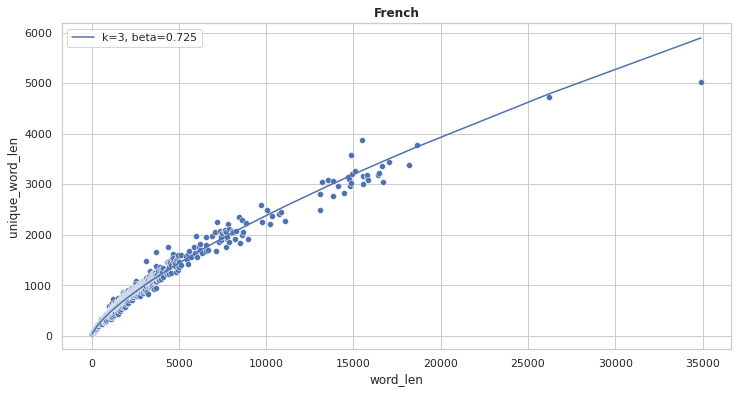

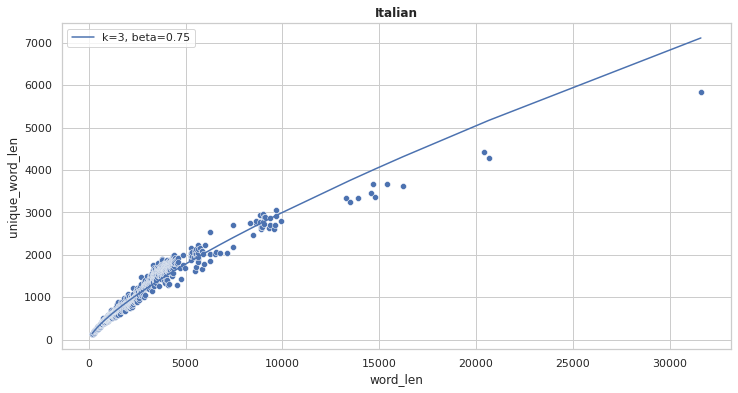

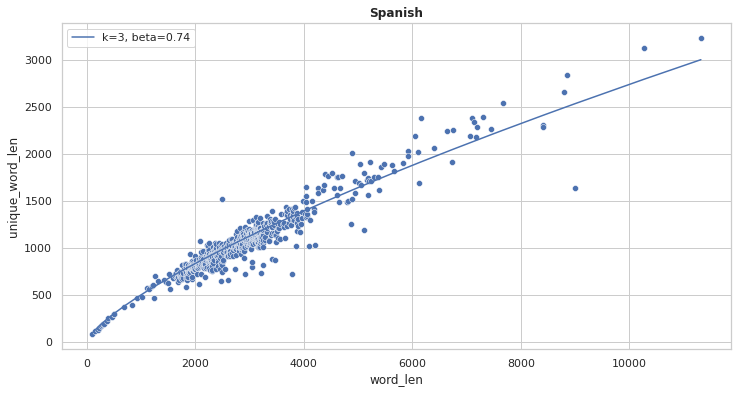

In [17]:
import nltk
from nltk.tokenize import word_tokenize

df['language'].replace('Spanish; Castilian', 'Spanish', inplace=True)
df['tokenized'] = [word_tokenize(v, language=df.iloc[i]['language'].lower()) for i, v in enumerate(df['text'])]
df['tokenized_cleaned'] = [[j.lower() for j in i if any(k.isalnum() for k in j)] for i in df['tokenized']]
df['text_cleaned'] = [' '.join(i) for i in df['tokenized_cleaned']]

issue_df = pd.DataFrame(df.groupby(['filename', 'language'])['text_cleaned'].apply(' '.join))
issue_df['word_len'] = [len(i.strip().split()) for i in issue_df['text_cleaned']]
issue_df['unique_word_len'] = [len(set(i.strip().split())) for i in issue_df['text_cleaned']]
issue_df['type-token-ratio'] = issue_df['unique_word_len']/issue_df['word_len']

issue_df.reset_index(inplace=True)
issue_df.set_index('filename', inplace=True)


language_list = ['French', 'Italian', 'Spanish']
new_df, language_fit = heap_language(issue_df, language_list)

In [18]:
df84.set_index('filename', inplace=True)
df84 = df84.join(new_df.drop(['language', 'text_cleaned'], axis=1))
df84['delta_TTR'] = df84['predicted_TTR'] - df84['type-token-ratio']
# topics
a = pd.DataFrame(df.groupby('filename')['topics'].apply(list))
a['unique_topics'] = [list(set([k for m in i for k in m])) 
                      for i in a['topics']]
df84 = df84.join(a[['unique_topics']])

In [21]:
df84.head(3)

,periodical_title,language,author,text,filtered_text,flesch_reading_ease,tags,p3,p1,p3/p1,word_len,unique_word_len,type-token-ratio,predicted_TTR,delta_TTR,unique_topics
filename,,,,,,,,,,,,,,,,
mws.2348.xml,El Regañón general,Spanish,Anónimo [Ventura Ferrer],NÚMERO PRIMERO. Miércoles 1.° de Junio de 1803...,Miércoles 1.° de Junio de 1803. DISCURSO QUE E...,47.92,"[[NÚMERO, NC, número], [PRIMERO, ADV, primero]...",1.244460,10.986337,0.113273,2894,1066,0.368348,0.377687,0.009338,"[Autopoetical Reflection, Theatre Literature A..."
mws.2349.xml,El Regañón general,Spanish,Anónimo [Ventura Ferrer],NÚM.° 2. Sábado 4 de Junio de 1803. COSTUMBRES...,Sábado 4 de Junio de 1803. INFORME DEL ASESOR ...,52.36,"[[NÚM.°, NC, <unknown>], [2, CARD, 2], [., FS,...",1.239697,10.913748,0.113590,3085,1142,0.370178,0.371462,0.001284,"[Manners and Customs, Theatre Literature Arts]"
mws.2350.xml,El Regañón general,Spanish,Anónimo [Ventura Ferrer],NÚM.° 3. Miércoles 8 de Junio de 1803. EDUCACI...,Miércoles 8 de Junio de 1803. CARTA QUE SE LE ...,58.45,"[[NÚM.°, NC, <unknown>], [3, CARD, 3], [., FS,...",1.241944,11.267859,0.110220,3152,1073,0.340419,0.369393,0.028974,"[Manners and Customs, Theatre Literature Arts]"


In [ ]:
df84.drop(['text', 'filtered_text', 'tags'], axis=1).to_csv('df84.csv')

# Plotting

In [22]:
df_g1 = df84[df84.periodical_title.isin(g1)].sort_values('periodical_title', 
                                                         ascending=False)

df_g2 = df84[df84.periodical_title.isin(g2)]
df_g3 = df84[df84.periodical_title.isin(g3)].set_index(
    'periodical_title').loc[g3].reset_index()
df_g4 = df84[df84.periodical_title.isin(g4)]
df_g5 = df84[df84['periodical_title'].isin(g5)].copy()

## Plot Flesch Reading Ease

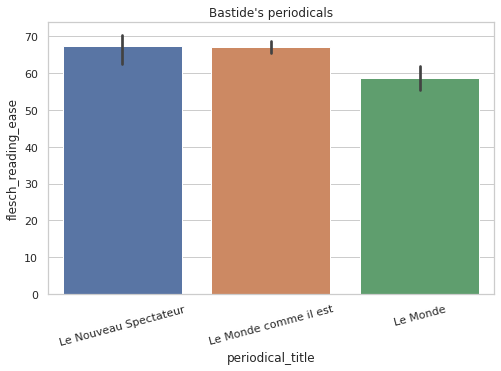

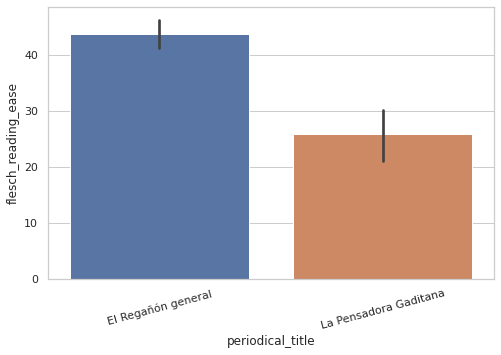

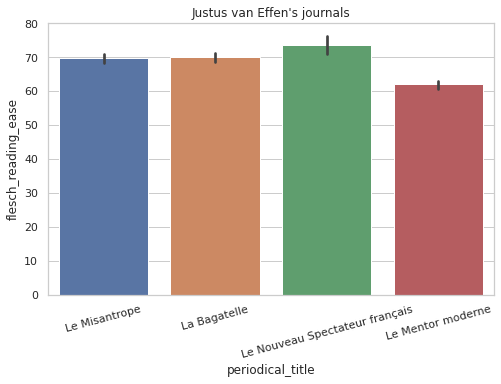

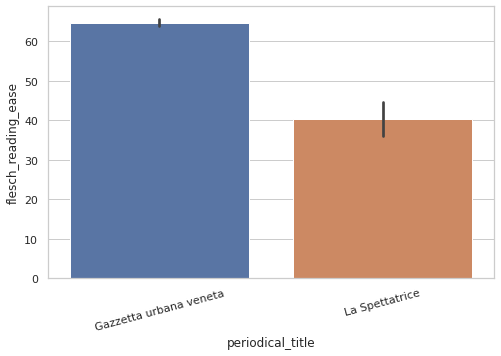

In [23]:
plot_flesch(df_g1, "Bastide's periodicals")
plot_flesch(df_g2)
plot_flesch(df_g3, title="Justus van Effen's journals")
plot_flesch(df_g4)

## Plot Perplexity

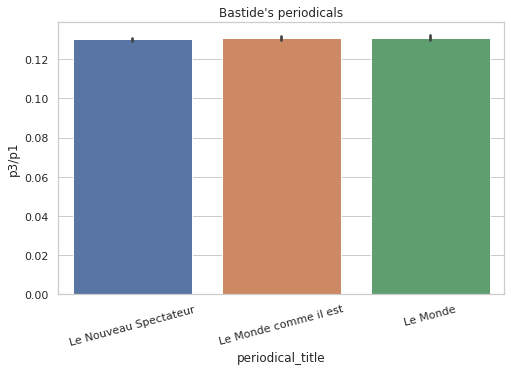

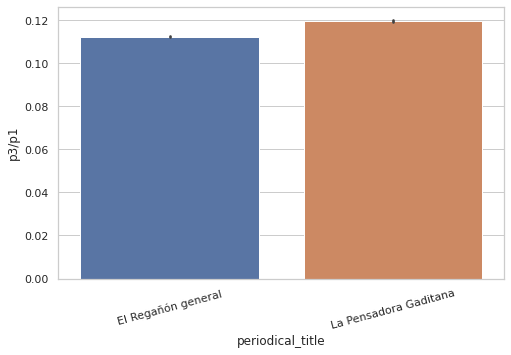

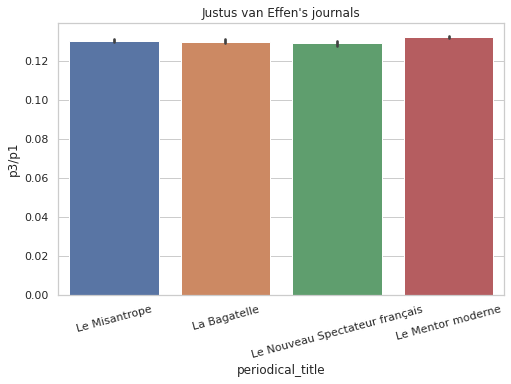

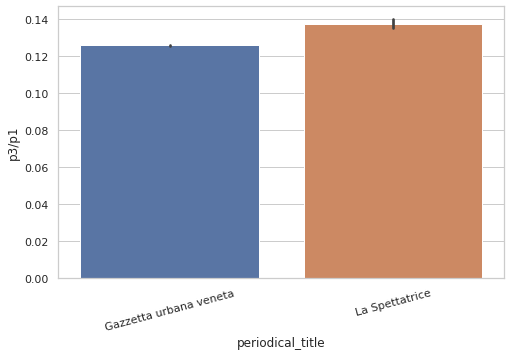

In [24]:
plot_flesch(df_g1, title="Bastide's periodicals",
           y='p3/p1') 
plot_flesch(df_g2, y='p3/p1') 
plot_flesch(df_g3, y='p3/p1', title="Justus van Effen's journals") 
plot_flesch(df_g4, y='p3/p1') 

## Plot Delta TTR

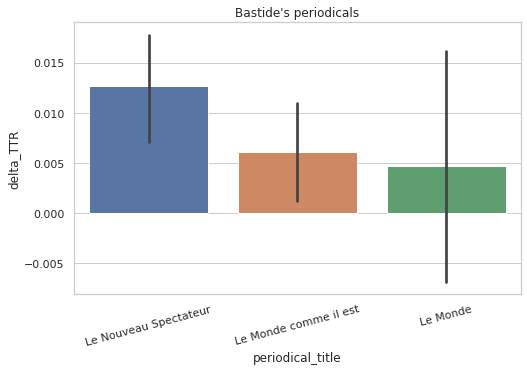

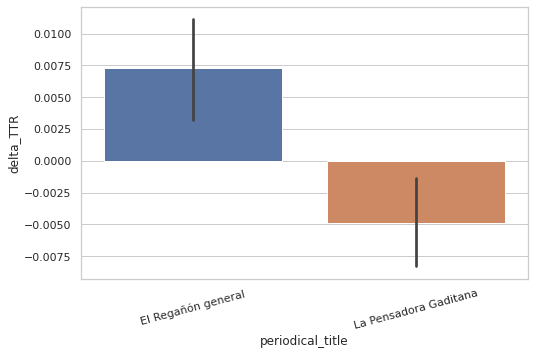

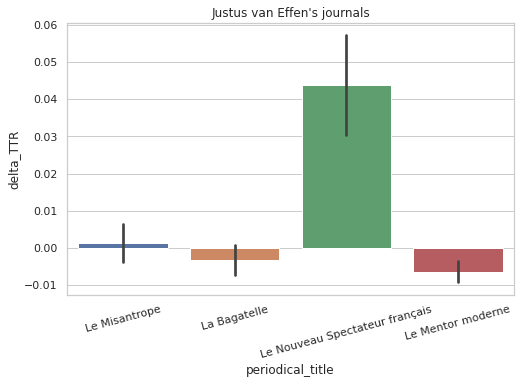

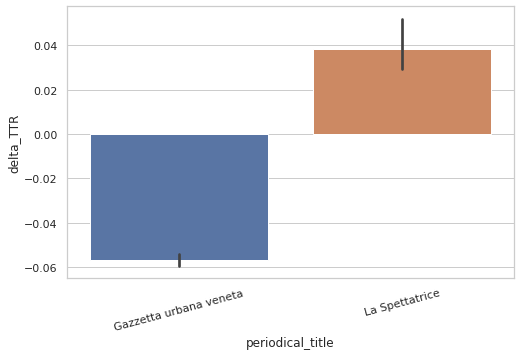

In [25]:
plot_flesch(df_g1, title="Bastide's periodicals",
           y='delta_TTR') 
plot_flesch(df_g2, y='delta_TTR') 
plot_flesch(df_g3, y='delta_TTR', title="Justus van Effen's journals") 
plot_flesch(df_g4, y='delta_TTR') 

# Topics

In [ ]:
col_new = 'Topics'
df_g5[col_new] = ''
s = ['Science' in i for i in df_g5['unique_topics']]
i = ['Image of Women' in m for m in df_g5['unique_topics']]
df_g5.loc[df_g5[s].index, col_new] = 'Science'
df_g5.loc[df_g5[i].index, col_new] = 'Image of Women'
r5 = df_g5[df_g5[col_new].isin(['Science', 'Image of Women'])]

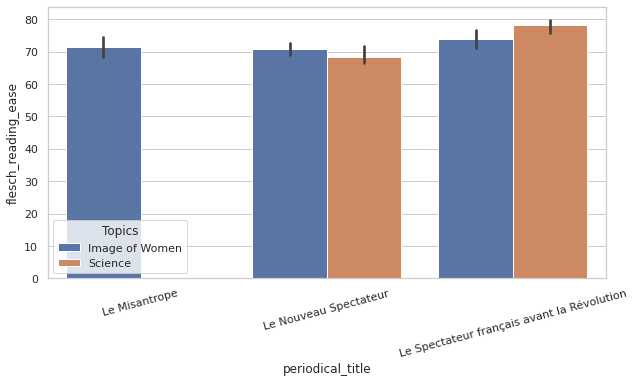

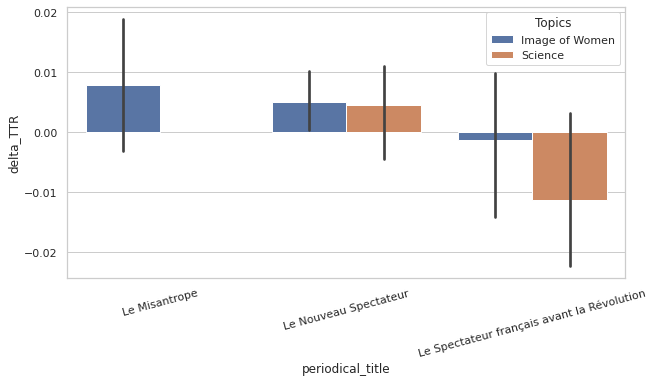

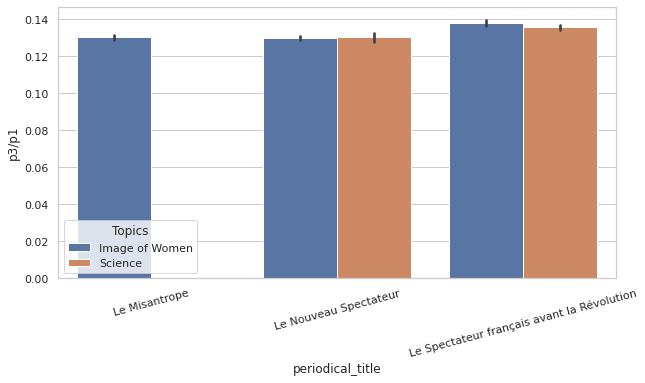

In [28]:
for y_col in ['flesch_reading_ease', 'delta_TTR', 'p3/p1']:
    plt.figure(figsize=(10, 5))
    ax = sns.barplot(x='periodical_title', y=y_col, hue=col_new,
                         data=r5)
    plt.xticks(rotation=15);

In [ ]:
r5.drop(['text', 'filtered_text', 'tags'], axis=1).to_csv('r5.csv')